In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

plt.style.use('seaborn')
%matplotlib inline
sns.set()

In [2]:
def spec_fit(x, c0, c1, c2, c3, w1, w2, f1):
    '''
    A function for fitting peaks to spectra.
    This fit function was copy-pasted in as text from David's fit function on 5/11/21.
    There are two water peaks (free water and bound water) modeled as gaussian peaks w1 and w2.
    There is the f1 fatty acid peak.
    There is a three-term polynomial function.

    :param x: input data
    :param c0: polynomial term 1
    :param c1: polynomial term 2
    :param c2: polynomial term 3
    :param c3: polynomial term 4
    :param w1: water peak term 1
    :param w2: water peak term 2
    :param f1: fatty acid peak
    :return:
    '''

    f_of_x = c0+c1*(x-1700)+c2*(x-1700)**2+c3*(x-1700)**3 + \
             w1*(0.0751747*np.exp(-(x-1903.82)**2/26.4725**2)+0.225213*np.exp(-(x-1942.21)**2/48.8781**2) +
                 0.005*np.exp(-(x-1779.71)**2/32.1869**2))/7.715 + \
             w2*(0.0280945*np.exp(-(x-1913.6)**2/25.0449**2)+0.103527*np.exp(-(x-1949.5)**2/52.2024**2))/3.07 + \
             f1*(0.31*np.exp(-(x-(1730-24))**2/17**2)+np.exp(-(x-1730)**2/17**2)+0.39 *
                 np.exp(-(x-(1730+31))**2/17**2))/25.484
    return f_of_x

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.

    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra

    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum

    '''
    number = df.shape[0]
    modelparams = np.empty((number, 7), dtype=float)
    modelcovar = np.empty((number, 7, 7), dtype=float)
    modeled_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_fit(wave_array, *modeled)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra


def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values

    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 6]


def create_modelparams_df(modelparams):
    columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    modelparams_df = pd.DataFrame(data=modelparams, columns=columns)
    return modelparams_df


def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.

    Input:  the modelcovar np.array created by model_fit().

    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[6]
    return f_sd_err


def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.

    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]


def get_visible_wavelength_vector(file_path, calibration_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        return wavelength_vector

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_absorbance_depth_df(file_path, insertion_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        absorbance_depth = h5_file[f"{insertion_path_str}/derived/absorbance_depth"][:]
        calibration_path_str = insertion_path_str[:17]
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        length = wavelength_vector.shape[0]
        columns = list(np.arange(0, length, 1))
        columns.append('force')
        columns.append('depth')
        dataframe = pd.DataFrame(data=absorbance_depth, columns=columns)
        return dataframe


def create_insertions_date_dataframe(spreadsheet, date_selection):
    df = pd.read_csv(spreadsheet)
    selected_df = df.loc[df['date'] == date_selection]
    return selected_df

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
spreadsheet = 'data/nirone_misc_insertions_210513.csv'

summary_df = pd.read_csv(spreadsheet)

all_parameters_df = pd.DataFrame()
all_absorbances_df = pd.DataFrame()
all_modeled_absorbances_df = pd.DataFrame()

for index in summary_df.index.unique():

    # Determine variables for getting the appropriate data
    file_name = summary_df['file_name'][index]
    file = path_name + file_name
    calibration_path = summary_df['session'][index] + '/' + summary_df['calibration'][index]
    insertion_path = calibration_path + '/' + summary_df['insertion'][index]
    insertion_type = summary_df['type'][index]
    insertion_target = summary_df['target'][index]
    date = summary_df['date'][index]
    c_unique = summary_df['c_unique'][index]
    i_unique = summary_df['i_unique'][index]

    # Get the wavelength vector
    waves = get_visible_wavelength_vector(file, calibration_path)

    # Get the absorbances dataset and make into dataframe
    absorbances = get_visible_insertion_absorbances(file, insertion_path)
    absorbances_df = pd.DataFrame(data=absorbances)

    # Run the model
    modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(absorbances_df, waves)

    # Create parameters and modeled spectra dataframes
    parameter_columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    parameters_df = pd.DataFrame(data=modelparams, columns=parameter_columns)
    parameters_df['file_name'] = file_name
    parameters_df['insertion'] = insertion_path
    parameters_df['date'] = date
    parameters_df['c_unique'] = c_unique
    parameters_df['i_unique'] = i_unique
    parameters_df['type'] = insertion_type
    parameters_df['target'] = insertion_target
    modeled_spectra_df = pd.DataFrame(data=modeled_spectra)

    # Calculate the standard deviation of the covariance matrix for the f1 term
    sd_err = extract_f_sd_err(modelcovar)
    parameters_df['sd_err'] = sd_err

    # Calculate RMSE
    squared_errors = np.square(residual_spectra)
    mse = np.mean(squared_errors, axis=1)
    rmse = np.sqrt(mse)
    parameters_df['rmse'] = rmse

    # Append the spectra to the overall dataframe
    all_absorbances_df = pd.concat([all_absorbances_df, absorbances_df], ignore_index=True, sort=False)
    all_parameters_df = pd.concat([all_parameters_df, parameters_df], ignore_index=True, sort=False)
    all_modeled_absorbances_df = pd.concat([all_modeled_absorbances_df, modeled_spectra_df], ignore_index=True, sort=False)

In [6]:
all_parameters_df

,c0,c1,c2,c3,w1,w2,f1,file_name,insertion,date,c_unique,i_unique,type,target,sd_err,rmse
0,0.575305,0.000103,8.280701e-08,6.476835e-11,0.306435,-0.121111,-0.080026,210331_nirone_tests/nirone_test5.h5,session001/cal001/ins001,3/31/21,c001,c001i01,stationary,dry spiked canister,0.000010,0.000522
1,0.575204,0.000101,8.962387e-08,1.416336e-10,0.322967,-0.160895,-0.076702,210331_nirone_tests/nirone_test5.h5,session001/cal001/ins001,3/31/21,c001,c001i01,stationary,dry spiked canister,0.000008,0.000472
2,0.575231,0.000103,8.736236e-08,5.366503e-11,0.268574,-0.083816,-0.083417,210331_nirone_tests/nirone_test5.h5,session001/cal001/ins001,3/31/21,c001,c001i01,stationary,dry spiked canister,0.000009,0.000477
3,0.575221,0.000103,8.984140e-08,1.035620e-11,0.301425,-0.111424,-0.087331,210331_nirone_tests/nirone_test5.h5,session001/cal001/ins001,3/31/21,c001,c001i01,stationary,dry spiked canister,0.000010,0.000506
4,0.575091,0.000105,9.636077e-08,-4.658890e-11,0.247839,-0.057250,-0.076908,210331_nirone_tests/nirone_test5.h5,session001/cal001/ins001,3/31/21,c001,c001i01,stationary,dry spiked canister,0.000009,0.000492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6059,0.072525,0.000359,-1.243745e-06,6.593547e-11,-0.012496,0.060552,0.011204,210510_schneider_park/schneider_park_210510.h5,session001/cal003/ins031,5/10/21,c012,c012i01,stationary,white blank,0.000004,0.000333
6060,0.072243,0.000365,-1.245058e-06,3.344637e-11,-0.005669,0.054909,0.011276,210510_schneider_park/schneider_park_210510.h5,session001/cal003/ins031,5/10/21,c012,c012i01,stationary,white blank,0.000004,0.000341
6061,0.071912,0.000372,-1.245382e-06,7.055769e-12,-0.016317,0.061974,0.012964,210510_schneider_park/schneider_park_210510.h5,session001/cal003/ins031,5/10/21,c012,c012i01,stationary,white blank,0.000005,0.000356
6062,0.071569,0.000379,-1.248663e-06,-2.729584e-11,-0.015423,0.063333,0.013892,210510_schneider_park/schneider_park_210510.h5,session001/cal003/ins031,5/10/21,c012,c012i01,stationary,white blank,0.000005,0.000353


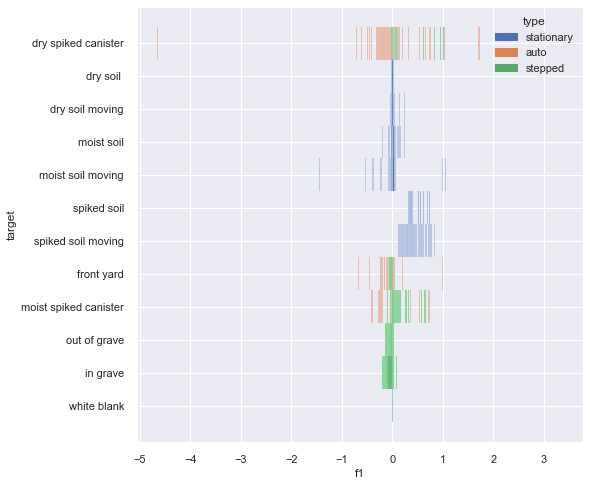

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(all_parameters_df, x='f1', y='target', hue='type')
plt.show()
plt.close()

In [26]:
all_parameters_df[['f1', 'sd_err', 'rmse']].describe()

,f1,sd_err,rmse
count,6064.000000,6.064000e+03,6064.000000
mean,0.068342,1.409788e-04,0.001257
std,0.239549,1.413660e-03,0.001456
min,-4.652538,4.693311e-07,0.000111
25%,-0.023067,1.904505e-05,0.000707
50%,0.001557,4.270196e-05,0.001059
75%,0.031255,6.661844e-05,0.001322
max,3.378451,9.350566e-02,0.049547


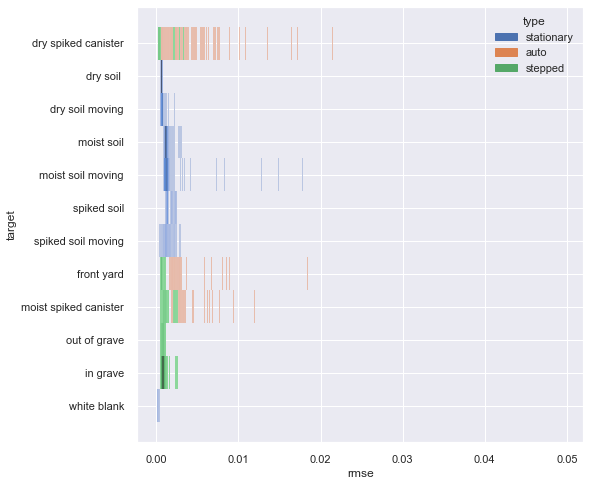

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(all_parameters_df, x='rmse', y='target', hue='type')
plt.show()
plt.close()

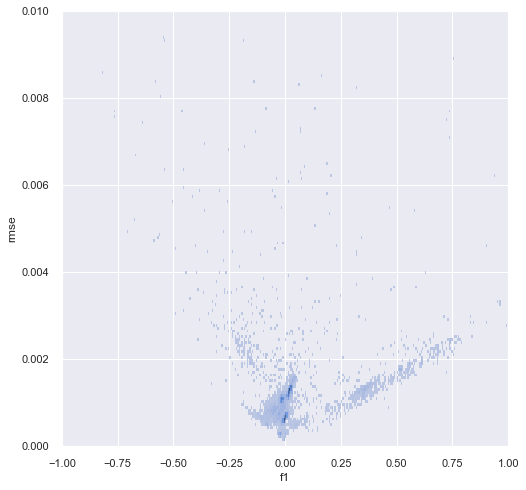

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.01)
sns.histplot(all_parameters_df, x='f1', y='rmse')
plt.show()
plt.close()

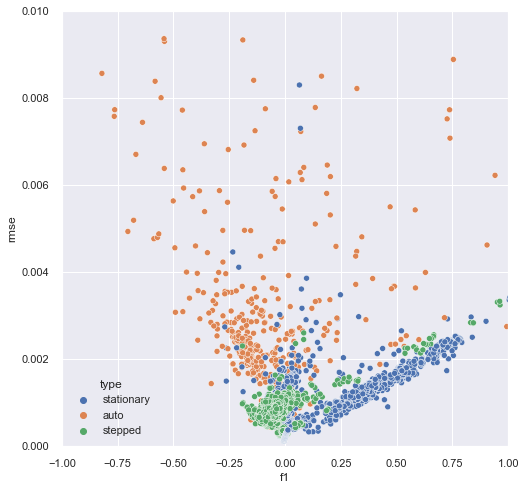

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.01)
sns.scatterplot(data=all_parameters_df, x='f1', y='rmse', hue='type')
plt.show()
plt.close()

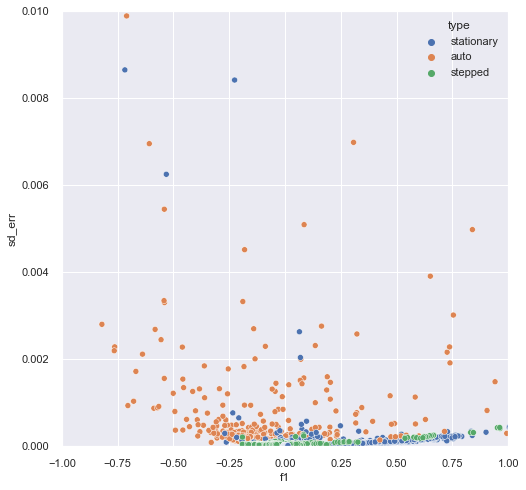

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.01)
sns.scatterplot(data=all_parameters_df, x='f1', y='sd_err', hue='type')
plt.show()
plt.close()

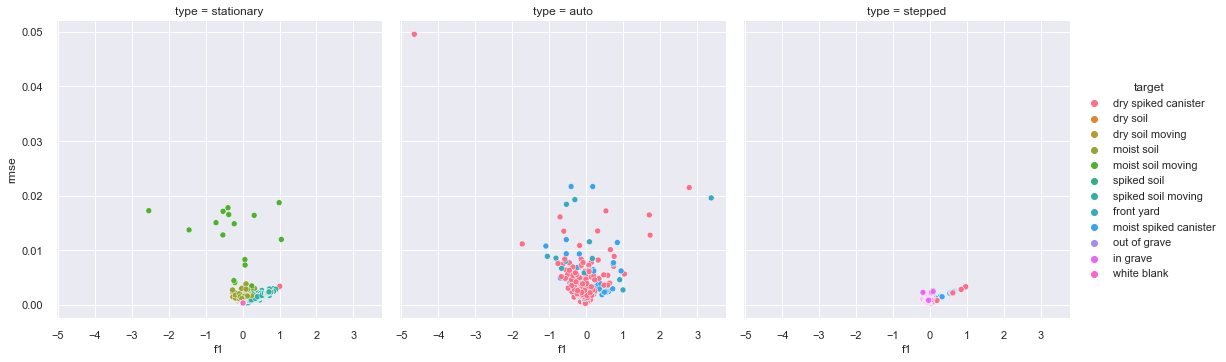

In [36]:
sns.relplot(data=all_parameters_df, x='f1', y='rmse', col='type', hue='target')

In [38]:
dry_spiked_canister = all_parameters_df.loc[all_parameters_df['target'] == 'dry spiked canister']

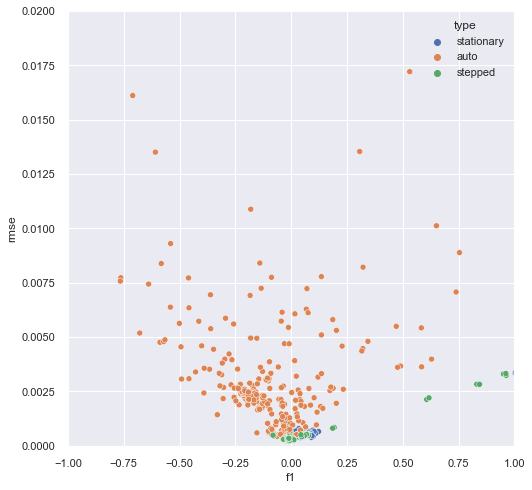

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.02)
sns.scatterplot(data=dry_spiked_canister, x='f1', y='rmse', hue='type')
plt.show()
plt.close()

In [42]:
moist_spiked_canister = all_parameters_df.loc[all_parameters_df['target'] == 'moist spiked canister']

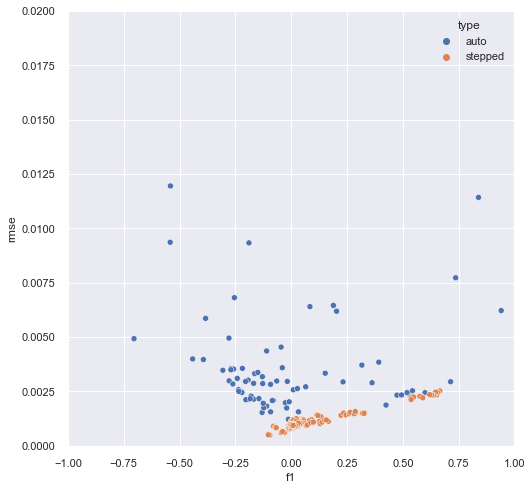

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.02)
sns.scatterplot(data=moist_spiked_canister, x='f1', y='rmse', hue='type')
plt.show()
plt.close()

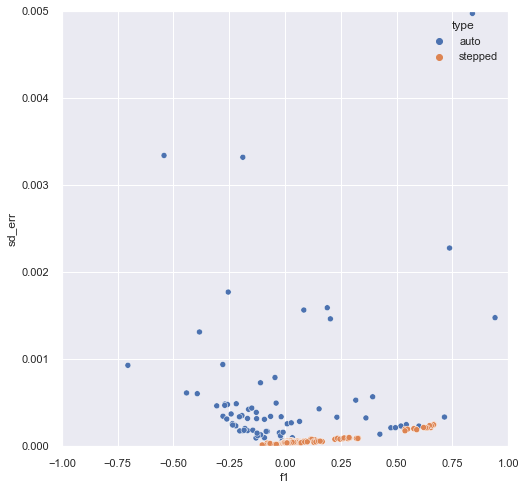

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(0.00, 0.005)
sns.scatterplot(data=moist_spiked_canister, x='f1', y='sd_err', hue='type')
plt.show()
plt.close()

In [46]:
schneider = all_parameters_df.loc[all_parameters_df['date'] == '5/10/21']

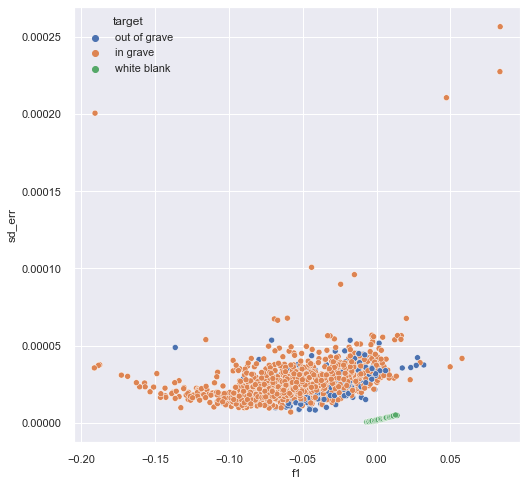

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.scatterplot(data=schneider, x='f1', y='sd_err', hue='target')
plt.show()
plt.close()

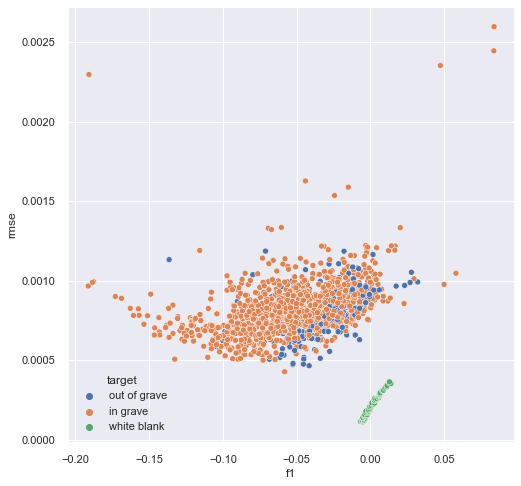

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.scatterplot(data=schneider, x='f1', y='rmse', hue='target')
plt.show()
plt.close()

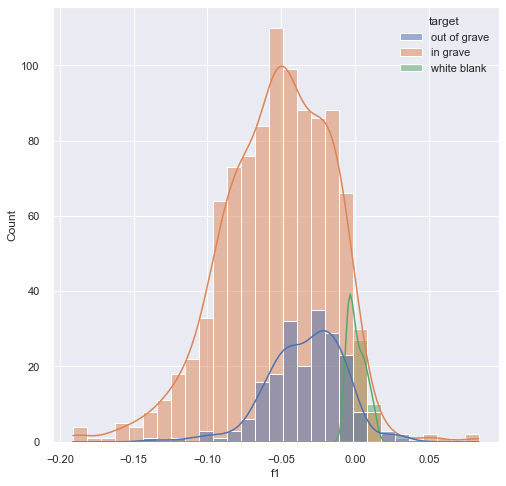

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=schneider, x='f1', hue='target', kde=True)
plt.show()
plt.close()

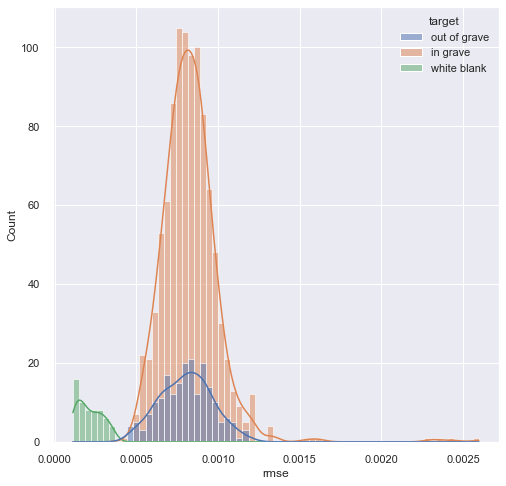

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=schneider, x='rmse', hue='target', kde=True)
plt.show()
plt.close()

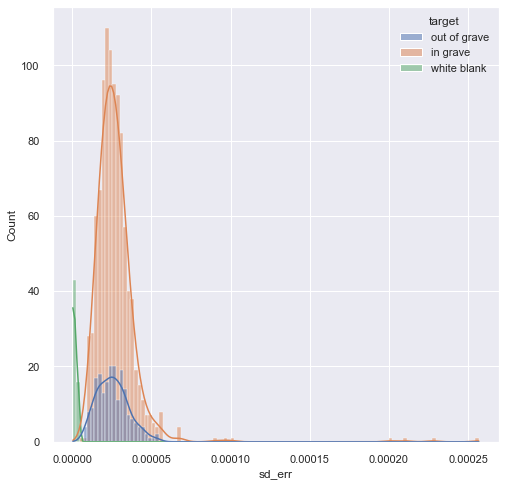

In [53]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=schneider, x='sd_err', hue='target', kde=True)
plt.show()
plt.close()

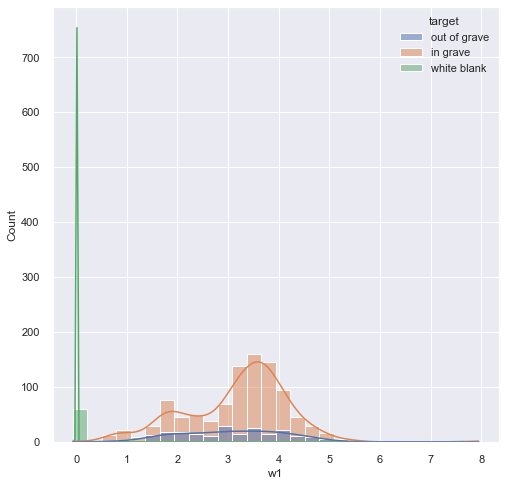

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=schneider, x='w1', hue='target', kde=True)
plt.show()
plt.close()

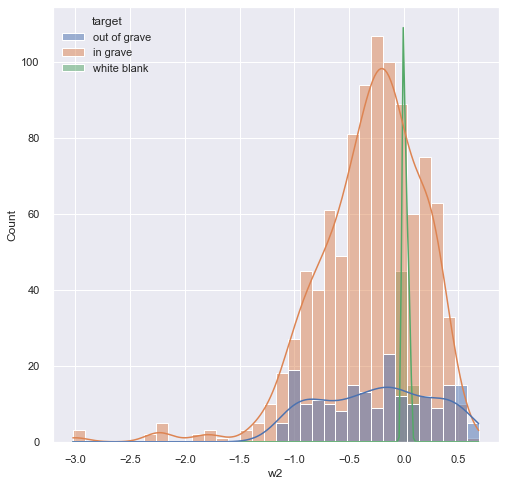

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=schneider, x='w2', hue='target', kde=True)
plt.show()
plt.close()

In [56]:
stationary = all_parameters_df.loc[all_parameters_df['type'] == 'stationary']

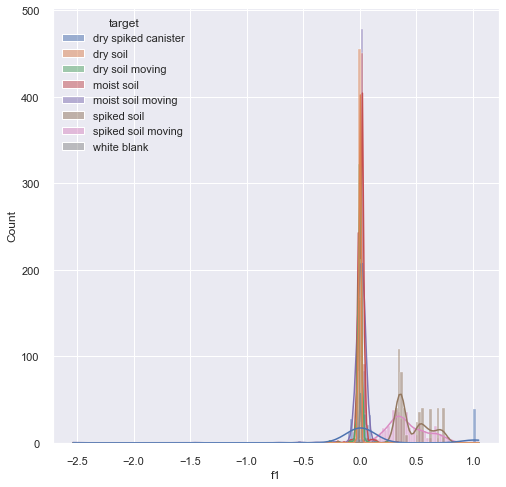

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=stationary, x='f1', hue='target', kde=True)
plt.show()
plt.close()

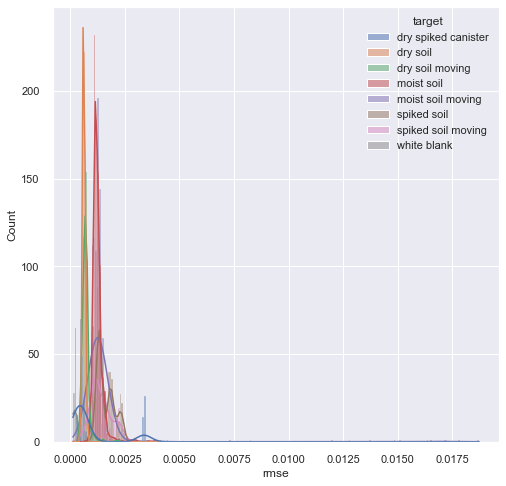

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.set_xlim(-1, 1)
# ax.set_ylim(0.00, 0.005)
sns.histplot(data=stationary, x='rmse', hue='target', kde=True)
plt.show()
plt.close()